In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b049a541cb3a9c313b3fd74bedc0ee9913bc2035cbbc4b9e46bc4194efb554e6
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [ ]:
import pandas as pd
import numpy as np
import json
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from collections import Counter
import random, os
from sklearn.model_selection import train_test_split
from seqeval.metrics.sequence_labeling import get_entities

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving labeling_dataset3.csv to labeling_dataset3.csv


In [ ]:
filename = "labeling_dataset3.csv"
df = pd.read_csv(filename)

df.columns = [c.strip().capitalize() for c in df.columns]
if "Token" not in df.columns or "Label" not in df.columns:
    raise ValueError("Pastikan ada kolom 'Token' dan 'Label' di CSV!")

# normalisasi label
df["Label"] = df["Label"].astype(str).str.strip().str.upper()
df["Label"] = df["Label"].replace({
    "O ": "O", " O": "O", "o": "O",
    "B-RES  ": "B-RES", "I-DATA ": "I-DATA", "B-TASK  ": "B-TASK",
    "O ": "O", "O  ": "O", "D": "O", "I": "O"
})
valid_labels = {"O", "B-TASK", "I-TASK", "B-MET", "I-MET", "B-DATA", "I-DATA", "B-RES", "I-RES"}
df.loc[~df["Label"].isin(valid_labels), "Label"] = "O"

print("Distribusi label bersih:")
print(Counter(df["Label"]))

abstracts, cur = [], []
for _, r in df.iterrows():
    if pd.isna(r["Token"]) or pd.isna(r["Label"]) or (r["Token"].strip() == "" and r["Label"].strip() == ""):
        if cur:
            abstracts.append(pd.DataFrame(cur))
            cur = []
    else:
        cur.append(r)
if cur:
    abstracts.append(pd.DataFrame(cur))

print(f"Total abstrak terdeteksi: {len(abstracts)}")

#filter hanya kalimat yang punya label non-O
def has_non_O(abstract_df):
    return any(lbl != "O" for lbl in abstract_df["Label"].tolist())

filtered_abstracts = [a for a in abstracts if has_non_O(a)]
print(f"Setelah filtering, tersisa: {len(filtered_abstracts)} abstrak")

combined_filtered = pd.concat(filtered_abstracts, ignore_index=True)
combined_filtered.to_csv("labeling_dataset3_filtered.csv", index=False)

Distribusi label bersih:
Counter({'O': 15935, 'B-MET': 1045, 'I-MET': 873, 'I-RES': 769, 'I-TASK': 512, 'B-RES': 484, 'B-TASK': 430, 'I-DATA': 275, 'B-DATA': 242})
Total abstrak terdeteksi: 101
Setelah filtering, tersisa: 101 abstrak


### **Split Dataset**

In [ ]:
def has_non_O(abstract_df):
    return any(lbl != "O" for lbl in abstract_df["Label"].tolist())


dominant_labels_all = []
for abs_df in abstracts:
    labels = abs_df["Label"].dropna().tolist()
    if len(labels) == 0:
        dominant_labels_all.append("O")
    else:
        dominant = max(set(labels), key=labels.count)
        dominant_labels_all.append(dominant.strip().upper())

#stratified split 80/10/10 based on dominant labels
train_idx, temp_idx = train_test_split(
    range(len(abstracts)),
    test_size=0.2,
    stratify=dominant_labels_all,
    random_state=42
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=np.array(dominant_labels_all)[temp_idx],
    random_state=42
)

train = [abstracts[i] for i in train_idx]
dev  = [abstracts[i] for i in val_idx]
test = [abstracts[i] for i in test_idx]


print(f"Train: {len(train)} | Dev: {len(dev)} | Test: {len(test)}")

def combine(abs_list, cols):
    res = pd.DataFrame(columns=cols)
    for a in abs_list:
        res = pd.concat([res, a, pd.DataFrame([{"Token": None, "Label": None}])], ignore_index=True)
    return res

os.makedirs("splitted_dataset_filtered", exist_ok=True)
combine(train, df.columns).to_csv("splitted_dataset_filtered/train.csv", index=False)
combine(dev, df.columns).to_csv("splitted_dataset_filtered/dev.csv", index=False)
combine(test, df.columns).to_csv("splitted_dataset_filtered/test.csv", index=False)

Train: 80 | Dev: 10 | Test: 11


### **Tokenization (WordPiece)**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def split_abstracts(df):
    abstracts, current_abs = [], {"tokens": [], "labels": []}
    for _, row in df.iterrows():
        if pd.isna(row["Token"]) or pd.isna(row["Label"]):
            if current_abs["tokens"]:
                abstracts.append(current_abs)
                current_abs = {"tokens": [], "labels": []}
        else:
            current_abs["tokens"].append(str(row["Token"]))
            current_abs["labels"].append(str(row["Label"]))
    if current_abs["tokens"]:
        abstracts.append(current_abs)
    return abstracts

train_data = split_abstracts(pd.read_csv("splitted_dataset_filtered/train.csv"))
dev_data = split_abstracts(pd.read_csv("splitted_dataset_filtered/dev.csv"))
test_data = split_abstracts(pd.read_csv("splitted_dataset_filtered/test.csv"))

print(f"Train: {len(train_data)}, Dev: {len(dev_data)}, Test: {len(test_data)} abstrak")

Train: 80, Dev: 10, Test: 11 abstrak


In [ ]:
train_dataset = Dataset.from_dict({
    "tokens": [d["tokens"] for d in train_data],
    "labels": [d["labels"] for d in train_data],
})
dev_dataset = Dataset.from_dict({
    "tokens": [d["tokens"] for d in dev_data],
    "labels": [d["labels"] for d in dev_data],
})
test_dataset = Dataset.from_dict({
    "tokens": [d["tokens"] for d in test_data],
    "labels": [d["labels"] for d in test_data],
})

dataset = DatasetDict({
    "train": train_dataset,
    "validation": dev_dataset,
    "test": test_dataset
})

### **Contoh Tokenization**

In [ ]:
filename = "labeling_dataset3.csv"
df = pd.read_csv(filename)

df.columns = [c.strip().capitalize() for c in df.columns]

abstracts = []
current = []

for _, row in df.iterrows():
    token = str(row["Token"]).strip() if pd.notna(row["Token"]) else ""
    label = str(row["Label"]).strip() if pd.notna(row["Label"]) else ""

    if token == "" and label == "":
        if current:
            abstracts.append(current)
            current = []
    else:
        current.append((token, label))

if current:
    abstracts.append(current)

print(f"Total abstrak: {len(abstracts)}")

idx = 0
tokens, labels = zip(*abstracts[idx])

print("\n=== Contoh Data Labeling ===")
for t, l in zip(tokens, labels):
    print(f"{t:15} | {l}")

text = " ".join(tokens)
print("\n=== Abstrak Gabungan ===")
print(text)

tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
encoding = tokenizer(text, return_offsets_mapping=True)

print("\n=== Hasil WordPiece Tokenization ===")
for tok, (start, end) in zip(
    tokenizer.convert_ids_to_tokens(encoding["input_ids"]),
    encoding["offset_mapping"]
):
    if start != end:
        print(f"{tok:15} -> {text[start:end]}")

print("\n=== Detokenisasi ===")
detok = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(encoding["input_ids"])
)
print(detok)


Total abstrak: 100

=== Contoh Data Labeling ===
Sulitnya        | O
mengelola       | O
dokumen         | O
administratif   | O
di              | O
Kapel           | O
St              | O
.               | O
Yohanes         | O
Rasul           | O
yang            | O
dilakukan       | O
secara          | O
manual          | O
sehingga        | O
rentan          | O
terhadap        | O
human           | O
error           | O
seperti         | O
kesalahan       | O
pencatatan      | O
hingga          | O
kehilangan      | O
dokumen         | O
.               | O
Penelitian      | O
ini             | O
bertujuan       | O
mengatasi       | O
masalah         | O
tersebut        | O
dengan          | O
mengolah        | O
data            | B-DATA
arsip           | I-DATA
milik           | I-DATA
kapel           | I-DATA
yang            | I-DATA
berformat       | I-DATA
PDF             | I-DATA
dan             | I-DATA
citra           | I-DATA
(               | I-DATA
image           | I-D

### **Label Mapping**

In [ ]:
unique_labels = sorted(set(label for d in train_data for label in d["labels"]))
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
print("Label Mapping:")
print(label2id)

Label Mapping:
{'B-DATA': 0, 'B-MET': 1, 'B-RES': 2, 'B-TASK': 3, 'I-DATA': 4, 'I-MET': 5, 'I-RES': 6, 'I-TASK': 7, 'O': 8}


### **Tokenization for NER (tokenization and alignment)**

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=512
    )
    all_labels = []
    for i, labels in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[labels[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        all_labels.append(label_ids)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/80 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/11 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

df = pd.read_csv("labeling_dataset3.csv")

tokens, labels = [], []
for _, row in df.iterrows():
    if pd.isna(row["Token"]) or pd.isna(row["Label"]):
        if tokens:
            break
    else:
        tokens.append(str(row["Token"]))
        labels.append(str(row["Label"]))

print("=== Abstrak asli ===")
print(" ".join(tokens))
print("\nJumlah token:", len(tokens))

encoding = tokenizer(tokens, is_split_into_words=True, truncation=True, max_length=128)

word_ids = encoding.word_ids()
previous_word_idx = None
aligned_labels = []

for word_idx in word_ids:
    if word_idx is None:
        aligned_labels.append("—")
    elif word_idx != previous_word_idx:
        aligned_labels.append(labels[word_idx])
    else:
        aligned_labels.append("—")
    previous_word_idx = word_idx

tokens_tokenized = tokenizer.convert_ids_to_tokens(encoding["input_ids"])

print("\n=== Hasil Tokenization + Label Alignment ===")
for tok, lbl in zip(tokens_tokenized, aligned_labels):
    print(f"{tok:15} | {lbl}")


=== Abstrak asli ===
Sulitnya mengelola dokumen administratif di  Kapel St . Yohanes Rasul yang dilakukan secara manual sehingga rentan terhadap human error seperti kesalahan pencatatan hingga kehilangan dokumen . Penelitian ini bertujuan mengatasi masalah tersebut dengan mengolah data  arsip milik kapel yang berformat PDF dan  citra ( image ) , untuk diklasifikasikan ke dalam tiga kelas ( surat perizinan , undangan , dan  peminjaman ) serta mengekstrak informasi penting di dalamnya . Sistem terintegrasi ini menerapkan teknologi Optical Character Recognition ( OCR ) menggunakan PyTesseract dan  Natural Language Processing ( NLP ) berbasis model fine-tuned IndoBERT . Hasil pengujian model menunjukkan performa yang sangat tinggi , di mana sistem klasifikasi mencapai akurasi 93,6 % pada data  uji baru , sedangkan model Named Entity Recognition ( NER  ) berhasil meraih F1-Score sebesar 0.989 . pengujian penerimaan pengguna juga menunjukkan bahwa sistem ini sangat efektif , berhasil meningk

### **IndoBERT Model**

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Fine-tuning IndoBERT for NER**

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [
        [id2label[l] for l, p in zip(label_row, pred_row) if l != -100]
        for label_row, pred_row in zip(labels, predictions)
    ]
    true_preds = [
        [id2label[p] for l, p in zip(label_row, pred_row) if l != -100]
        for label_row, pred_row in zip(labels, predictions)
    ]

    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_true_preds = [item for sublist in true_preds for item in sublist]


    return {
        "precision": precision_score(flat_true_labels, flat_true_preds, average='macro', zero_division=0),
        "recall": recall_score(flat_true_labels, flat_true_preds, average='macro', zero_division=0),
        "f1": f1_score(flat_true_labels, flat_true_preds, average='macro', zero_division=0),
        "accuracy": accuracy_score(flat_true_labels, flat_true_preds)
    }

In [ ]:
args = TrainingArguments(
    output_dir="./results",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
    gradient_accumulation_steps=2,
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

/tmp/ipython-input-2463533004.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.352700,0.898595,0.180026,0.225269,0.191285,0.796256
2,0.790200,0.647153,0.481444,0.232593,0.253893,0.822137
3,0.600000,0.566481,0.566502,0.385631,0.408865,0.846366
4,0.485800,0.493819,0.528018,0.454138,0.471441,0.854075
5,0.410600,0.464479,0.587128,0.520526,0.517027,0.855176
6,0.362700,0.416586,0.621855,0.512789,0.538127,0.873899
7,0.313700,0.408615,0.621097,0.546459,0.549678,0.871696
8,0.278800,0.406063,0.686780,0.573725,0.574031,0.870595
9,0.246200,0.401434,0.652836,0.565043,0.579821,0.874449
10,0.217200,0.409242,0.644920,0.594977,0.598994,0.876101


TrainOutput(global_step=100, training_loss=0.32274156749248506, metrics={'train_runtime': 506.9201, 'train_samples_per_second': 3.156, 'train_steps_per_second': 0.197, 'total_flos': 260304787320624.0, 'train_loss': 0.32274156749248506, 'epoch': 20.0})

**Grafik training**

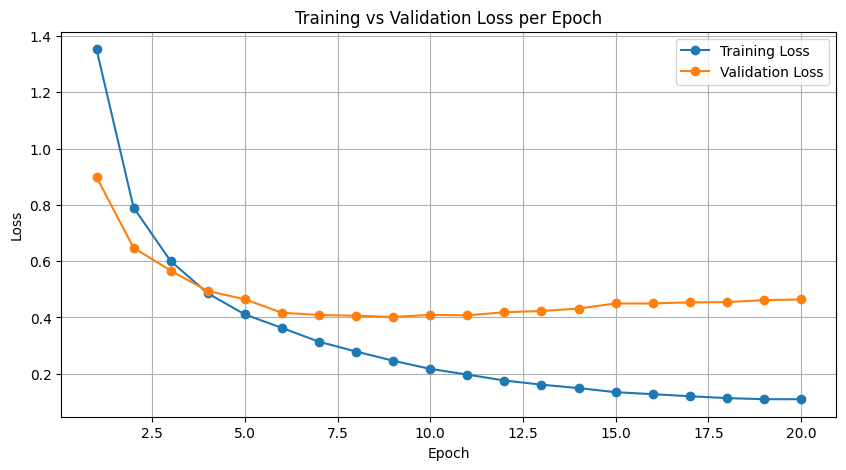

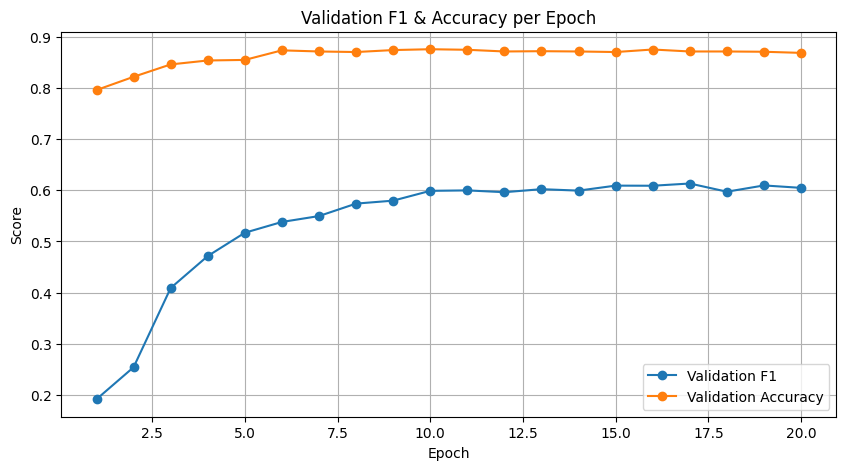

In [ ]:
history = pd.DataFrame(trainer.state.log_history)

loss_history = history[history["loss"].notnull()]
eval_history = history[history["eval_loss"].notnull()]

plt.figure(figsize=(10,5))
plt.plot(loss_history["epoch"], loss_history["loss"], label="Training Loss", marker='o')
plt.plot(eval_history["epoch"], eval_history["eval_loss"], label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

if "eval_f1" in eval_history.columns:
    plt.figure(figsize=(10,5))
    plt.plot(eval_history["epoch"], eval_history["eval_f1"], label="Validation F1", marker='o')
    if "eval_accuracy" in eval_history.columns:
        plt.plot(eval_history["epoch"], eval_history["eval_accuracy"], label="Validation Accuracy", marker='o')
    plt.title("Validation F1 & Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("⚠️ Tidak ditemukan metric F1 pada log. Pastikan compute_metrics mengembalikan F1.")


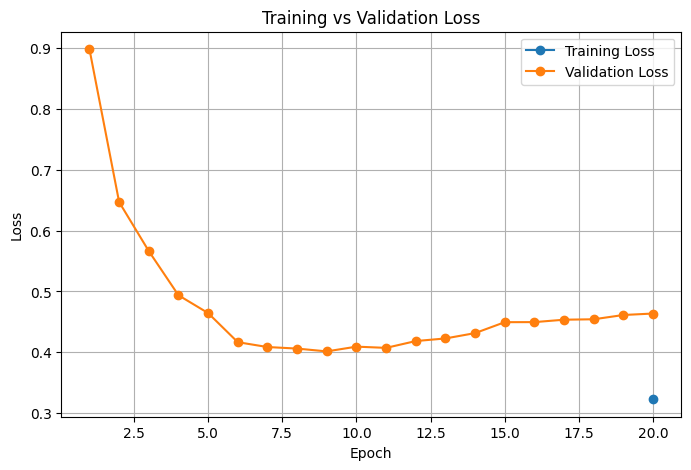

In [ ]:
logs = trainer.state.log_history

log_df = pd.DataFrame(logs)

train_loss = log_df[log_df["train_loss"].notna()][["epoch", "train_loss"]]
eval_loss = log_df[log_df["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["epoch"], train_loss["train_loss"], label="Training Loss", marker="o")
plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

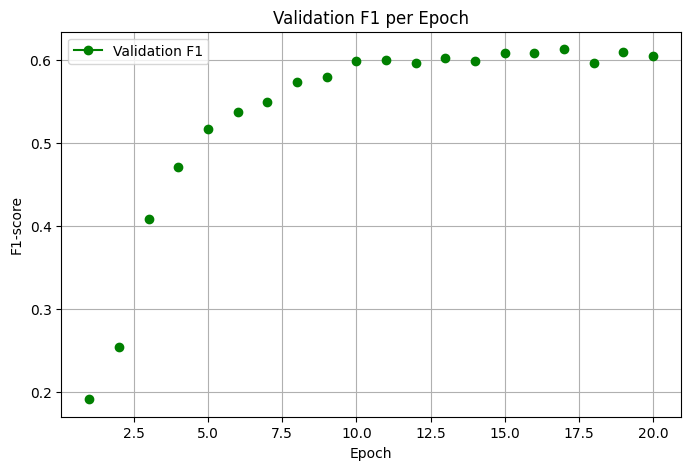

In [ ]:
if "eval_f1" in log_df.columns:
    plt.figure(figsize=(8,5))
    plt.plot(log_df["epoch"], log_df["eval_f1"], label="Validation F1", color="green", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.title("Validation F1 per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

### **Evaluasi & Contoh Prediksi**

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predictions = np.argmax(predictions, axis=2)

def fix_bio_sequence(preds, id2label):
    fixed_preds = []
    for seq in preds:
        corrected = []
        prev_tag = "O"
        for p in seq:
            tag = id2label[p]
            if tag.startswith("I-"):
                if not (prev_tag.endswith(tag[2:]) and prev_tag != "O"):
                    tag = "B-" + tag[2:]
            elif tag == "O":
                prev_tag = "O"
            prev_tag = tag
            corrected.append(tag)
        fixed_preds.append(corrected)
    return fixed_preds

predicted_labels = fix_bio_sequence(predictions, id2label)

print("\n=== Contoh Prediksi dari Test Set ===")
for i in range(1):
    tokens = dataset["test"][i]["tokens"]
    true = dataset["test"][i]["labels"]
    preds = predicted_labels[i][:len(tokens)]
    for t, l, p in zip(tokens, true, preds):
        print(f"{t:15} | Label: {l:10} | Pred: {p}")


=== Contoh Prediksi dari Test Set ===
Penyakit        | Label: O          | Pred: O
jantung         | Label: O          | Pred: O
merupakan       | Label: O          | Pred: O
penyebab        | Label: O          | Pred: O
utama           | Label: O          | Pred: O
kematian        | Label: O          | Pred: O
di              | Label: O          | Pred: O
dunia           | Label: O          | Pred: O
dan             | Label: O          | Pred: O
sering          | Label: O          | Pred: O
tidak           | Label: O          | Pred: O
terdeteksi      | Label: O          | Pred: O
sejak           | Label: O          | Pred: O
dini            | Label: O          | Pred: O
karena          | Label: O          | Pred: O
keterbatasan    | Label: O          | Pred: O
informasi       | Label: O          | Pred: O
dan             | Label: O          | Pred: O
biaya           | Label: O          | Pred: O
pemeriksaan     | Label: O          | Pred: O
.               | Label: O          | Pre

**Token-Level Evaluation**

In [ ]:
def evaluate_token_level(predictions, labels, id2label):
    true_labels = [
        [id2label[l] for l in label_row if l != -100]
        for label_row in labels
    ]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction_row, label_row) if l != -100]
        for prediction_row, label_row in zip(predictions, labels)
    ]


    flat_true_labels = [item for sublist in true_labels for item in sublist]
    flat_true_predictions = [item for sublist in true_predictions for item in sublist]

    print("\n=== Token-Level Classification Report ===")
    print(classification_report(flat_true_labels, flat_true_predictions, zero_division=0))

    print("\n=== Token-Level Metrics ===")
    acc = accuracy_score(flat_true_labels, flat_true_predictions)
    prec = precision_score(flat_true_labels, flat_true_predictions, average='macro', zero_division=0)
    rec = recall_score(flat_true_labels, flat_true_predictions, average='macro', zero_division=0)
    f1_macro = f1_score(flat_true_labels, flat_true_predictions, average='macro', zero_division=0)
    f1_micro = f1_score(flat_true_labels, flat_true_predictions, average='micro', zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro
    }

    return metrics

In [ ]:
metrics = evaluate_token_level(predictions, labels, id2label)


=== Token-Level Classification Report ===
              precision    recall  f1-score   support

      B-DATA       0.60      0.33      0.43        27
       B-MET       0.66      0.77      0.71       124
       B-RES       0.74      0.77      0.75        52
      B-TASK       0.65      0.77      0.71        44
      I-DATA       0.24      0.16      0.19        25
       I-MET       0.70      0.69      0.70       103
       I-RES       0.68      0.73      0.71        82
      I-TASK       0.46      0.57      0.51        56
           O       0.95      0.93      0.94      1622

    accuracy                           0.87      2135
   macro avg       0.63      0.64      0.63      2135
weighted avg       0.87      0.87      0.87      2135


=== Token-Level Metrics ===
Accuracy: 0.8712
Precision: 0.6309
Recall: 0.6364
F1 Score (Macro): 0.6268
F1 Score (Micro): 0.8712


**Partial Match Evaluation**

In [ ]:
def partial_match_f1(y_true, y_pred):

    partial_tp = 0  # true positive (overlap)
    false_positive = 0
    false_negative = 0

    for true_seq, pred_seq in zip(y_true, y_pred):
        true_entities = get_entities(true_seq)
        pred_entities = get_entities(pred_seq)

        matched_true = set()
        matched_pred = set()

        for i, true_ent in enumerate(true_entities):
            for j, pred_ent in enumerate(pred_entities):
                true_label, true_start, true_end = true_ent
                pred_label, pred_start, pred_end = pred_ent

                # cek overlap antar entitas dengan label yang sama
                if true_label == pred_label and not (true_end < pred_start or pred_end < true_start):
                    partial_tp += 1
                    matched_true.add(i)
                    matched_pred.add(j)

        false_positive += len(pred_entities) - len(matched_pred)
        false_negative += len(true_entities) - len(matched_true)

    precision = partial_tp / (partial_tp + false_positive + 1e-10)
    recall = partial_tp / (partial_tp + false_negative + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    metrics = {
        "partial_precision": precision,
        "partial_recall": recall,
        "partial_f1": f1
    }

    return metrics

In [ ]:
true_labels = [
    [id2label[l] for l in label_row if l != -100]
    for label_row in labels
]
true_predictions = [
    [id2label[p] for (p, l) in zip(pred_row, label_row) if l != -100]
    for pred_row, label_row in zip(predictions, labels)
]

partial_metrics = partial_match_f1(true_labels, true_predictions)

print("\n=== Partial Match Metrics ===")
print(f"Precision: {partial_metrics['partial_precision']:.4f}")
print(f"Recall: {partial_metrics['partial_recall']:.4f}")
print(f"F1-score: {partial_metrics['partial_f1']:.4f}")



=== Partial Match Metrics ===
Precision: 0.6877
Recall: 0.8759
F1-score: 0.7705


**Confusion Matrix**

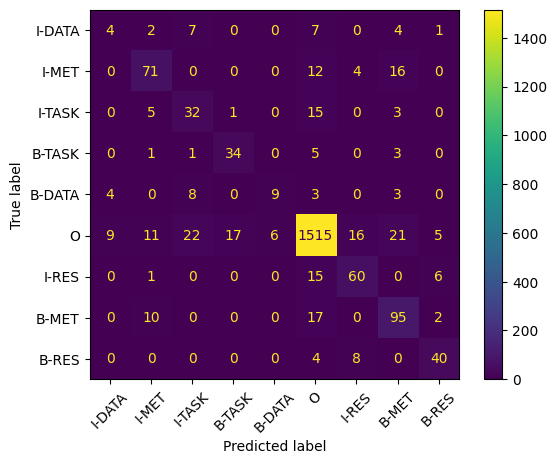

In [ ]:
true_labels = [
    [id2label[l] for l in label_row if l != -100]
    for label_row in labels
]
true_predictions = [
    [id2label[p] for (p, l) in zip(prediction_row, label_row) if l != -100]
    for prediction_row, label_row in zip(predictions, labels)
]

flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_predictions = [item for sublist in true_predictions for item in sublist]

cm = confusion_matrix(flat_true_labels, flat_true_predictions, labels=list(set(flat_true_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(flat_true_labels)))
disp.plot(xticks_rotation=45)
plt.show()

**Learning Curve**

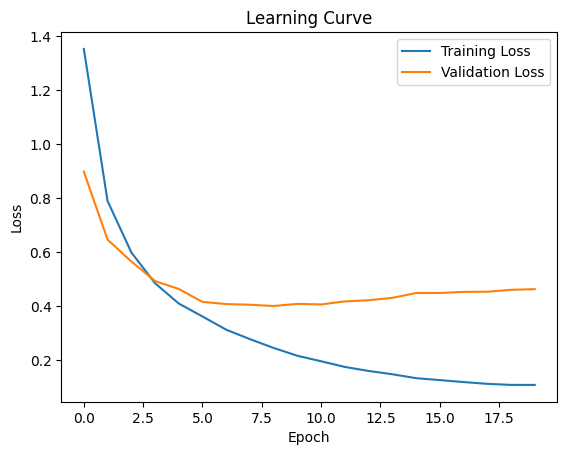

In [ ]:
training_logs = trainer.state.log_history
train_loss = [x["loss"] for x in training_logs if "loss" in x]
eval_loss = [x["eval_loss"] for x in training_logs if "eval_loss" in x]

plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curve")
plt.show()